In [1]:
import sys
sys.path.extend(['/home/quic/QUIC-Projects'])

import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
DATA_DIR = Path('/home/quic/QUIC-Projects/summary_ipynb/2021/10 October/15 Fri/Exp2(trs=64)')

## Fig. 3 (a)

In [10]:
from pandas import read_csv, DataFrame
data = read_csv(DATA_DIR/'Samples/sample_summary.csv')

def clean_pivot(df, agg_func='mean'):
    temp = df.pivot_table(values=list(df.columns[4:]), index=list(df.columns[0:4]), aggfunc=agg_func)
    return DataFrame(columns=list(temp.index.names)+list(temp.columns), data=np.hstack([np.asarray(list(temp.index)), temp.to_numpy()]))
for m in ['mean', 'median', 'std', 'min', 'max']:
    clean_pivot(data, m).to_csv(DATA_DIR / f'summary({m}).csv', index=False)


X = np.load(DATA_DIR/'DataSets/X.npy')
Xt = np.load(DATA_DIR/'DataSets/Xt.npy')
y = np.load(DATA_DIR/'DataSets/y.npy')
yt = np.load(DATA_DIR/'DataSets/yt.npy')

In [11]:
from itertools import product
min_select_result = DataFrame(columns=data.columns)
for cid, ly in product(range(1, 20), range(1, 9)):
    min_val = min(data.loc[(data['circuit_id']==cid) & (data['layer']==ly)]['last_cost_avg'])
    data_df = data.loc[(data['circuit_id']==cid) & (data['layer']==ly)]
    min_select_result = min_select_result.append(data_df.loc[data_df['last_cost_avg']==min_val], ignore_index=True)
    
min_select_result.loc[min_select_result['circuit_id']==15]
    

,dataset,circuit_id,layer,num_params,expr,entcap,num_iter,last_cost_avg,accuracy
112,0,15,1,6,0.567396,0.677565,42,0.114346,0.921875
113,0,15,2,12,0.189553,0.744091,49,0.113266,0.937500
114,0,15,3,18,0.090994,0.874990,140,0.078434,0.968750
115,0,15,4,24,0.045076,0.894793,107,0.083107,0.953125
116,0,15,5,30,0.077400,0.922199,181,0.068390,0.921875
117,0,15,6,36,0.067235,0.925718,85,0.096779,0.875000
118,0,15,7,42,0.051004,0.935232,132,0.090435,0.953125
119,0,15,8,48,0.070495,0.936841,79,0.086998,0.890625


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
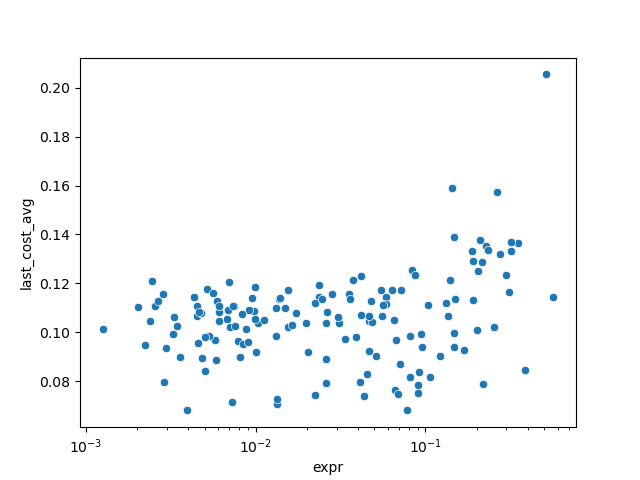

In [12]:
%matplotlib widget
import seaborn as sns
sns.scatterplot(data=min_select_result, x='expr', y='last_cost_avg')
# sns.scatterplot(data=min_select_result.loc[(min_select_result['expr']>0.07) & (min_select_result['expr']<0.1) & (min_select_result['last_cost_avg']<1)], x='expr', y='last_cost_avg', hue='layer', style='circuit_id')
plt.xscale('log')

In [13]:
# mask = (svm.predict(Xt)==yt)
# data.loc[(data['circuit_id']==15) & (data['layer']==4)]    
import json
with open(DATA_DIR / 'Samples/Circuit #15/layer=5/1/full_result.json', 'r') as f:
    f_vector = json.load(f)['f']
mask = (f_vector * (2*yt-1) > 0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
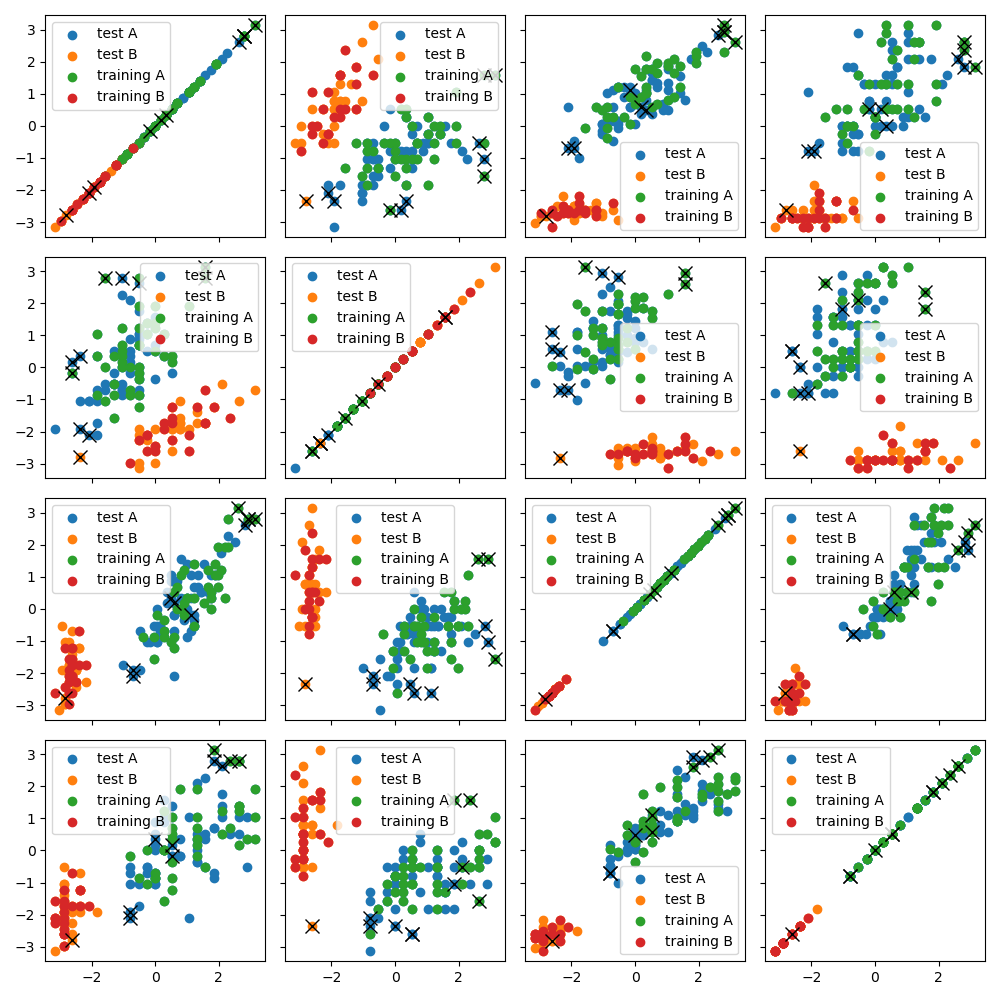

In [17]:
%matplotlib widget
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, squeeze=True, figsize=(10, 10))
from itertools import product
for e1, e2 in product(range(4), repeat=2):
    ax = axes[e1, e2]
    ax.scatter(Xt[yt==0, e1], Xt[yt==0, e2], label='test A')
    ax.scatter(Xt[yt==1, e1], Xt[yt==1, e2], label='test B')

    ax.scatter(X[y==0, e1], X[y==0, e2], label='training A')
    ax.scatter(X[y==1, e1], X[y==1, e2], label='training B')

    ax.plot(Xt[~mask, e1], Xt[~mask, e2], marker='x', mec='k', mfc='none', markersize=10, linestyle='none')

    ax.legend()
plt.tight_layout()

In [18]:
import dill
from tqdm.notebook import tqdm
# with open(DATA_DIR / 'Samples/Circuit #15/layer=4/4/nqsvm', 'rb') as f:
with open(DATA_DIR / 'Samples/Circuit #15/layer=5/1/nqsvm', 'rb') as f:
    qasvm = dill.load(f)
    
_init = qasvm.parameters.copy()
_init.update(qasvm.initial_point)
var_qc = qasvm.var_form.assign_parameters(dict(zip(qasvm.var_form.parameters, _init)))
var_qc.save_statevector()
result = qasvm.quantum_instance.execute(var_qc)
initial_point = np.abs(result.get_statevector()) ** 2

from copy import deepcopy
from classifiers.quantum.qasvm import PseudoNormQSVM
from classifiers.optimizer import tSPSA
from classifiers.callback import CostParamStorage
feature_map = deepcopy(qasvm.feature_map)
pqasvm = PseudoNormQSVM(data=qasvm.data, label=qasvm.label, quantum_instance=qasvm.quantum_instance, lamda=qasvm.lamda, feature_map=feature_map, var_form=None, initial_point=initial_point)

storage = CostParamStorage()
optimizer = tSPSA(maxiter=2**15, blocking=True, last_avg=16, callback=storage)
for epoch in tqdm(range(1, 2**15 + 1)):
    optimizer.step(pqasvm.cost_fn, pqasvm.parameters)
    if storage.num_accepted() > 2 * 16 and storage.last_cost_avg(2 * 16, ignore_rejected=True) < \
            storage.last_cost_avg(16, ignore_rejected=True):
        break
pqasvm.parameters = storage.last_avg(16, ignore_rejected=True)
last_cost = storage.last_cost_avg(16, ignore_rejected=True)

  0%|          | 0/32768 [00:00<?, ?it/s]

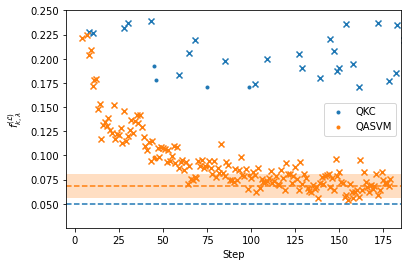

<Figure size 432x288 with 0 Axes>

In [19]:
%matplotlib inline
# with open(DATA_DIR / 'Samples/Circuit #15/layer=4/4/storage', 'rb') as f:
with open(DATA_DIR / 'Samples/Circuit #15/layer=5/1/storage', 'rb') as f:

    qasvm_storage = dill.load(f)
    
color1, color2 = '#1f77b4', '#ff7f0e'
# df1 = storage.data.iloc[:len(qasvm_storage.data)]
df1 = storage.data
df2 = qasvm_storage.data
plt.scatter(df1.loc[df1['Accepted']==True]['Step'], df1.loc[df1['Accepted']==True]['Cost'], marker='.', c=color1, label='QKC')
plt.scatter(df1.loc[df1['Accepted']==False]['Step'], df1.loc[df1['Accepted']==False]['Cost'], marker='x', c=color1)
plt.scatter(df2.loc[df1['Accepted']==True]['Step'], df2.loc[df1['Accepted']==True]['Cost'], marker='.', c=color2, label='QASVM')
plt.scatter(df2.loc[df1['Accepted']==False]['Step'], df2.loc[df1['Accepted']==False]['Cost'], marker='x', c=color2)
plt.axhline(last_cost, 0, 1, color=color1, linestyle='--')
plt.axhline(qasvm_storage.last_cost_avg(16, ignore_rejected=True), 0, 1, color=color2, linestyle='--')
plt.axhspan(ymin=qasvm_storage.last_cost_avg(16, ignore_rejected=True)-2*qasvm_storage.last_cost_std(16, ignore_rejected=True),
            ymax=qasvm_storage.last_cost_avg(16, ignore_rejected=True)+2*qasvm_storage.last_cost_std(16, ignore_rejected=True),
            xmin=0, xmax=1, facecolor=color2, alpha=0.25)
plt.ylim([None, 0.25])
plt.xlim([-5, len(df2)+5])
plt.xlabel('Step')
plt.ylabel(r'$f_{k, \lambda}^{(\mathcal{L})}$')
plt.legend()
plt.savefig('./figs/spsa_progress.eps', dpi=200)
plt.show()

In [20]:
from classifiers.convex.svm import BinarySVM
from qiskit_machine_learning.kernels import QuantumKernel

quantum_kernel = QuantumKernel(feature_map, enforce_psd=False, quantum_instance=pqasvm.quantum_instance)
def my_kernel(x, y):
    return (np.abs(quantum_kernel.evaluate([x], [y]))**2).item()
svm = BinarySVM(kernel=my_kernel, mutation='REDUCED_QASVM', k=pqasvm.lamda, C=None)

In [ ]:
svm.fit(pqasvm.data, pqasvm.label)
svm.result['dual objective']

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, sharey=True, squeeze=True, figsize=(8, 3))
ax = axes[0]
ax.errorbar(min_select_result['entcap'], min_select_result['last_cost_avg'], marker='.', linestyle='none', )#yerr=std_result['last_cost_avg'])
# plt.hlines(y=svm.result['dual objective'], xmin=min(result['expr']), xmax=max(result['expr']))
ax.axhline(y=last_cost)
ax.set_xlabel('Entanglement Capacity')
ax.set_ylabel(r'$\mathrm{min} \left\{ f_{k, \lambda}^{(\mathcal{L})} \right\}$')

ax = axes[1]
ax.errorbar(min_select_result['expr'], min_select_result['last_cost_avg'], marker='.', linestyle='none', )#yerr=std_result['last_cost_avg'])
ax.axhline(y=last_cost)
ax.set_xscale('log')
ax.set_xlabel('Expressiblity')
plt.tight_layout()

In [ ]:
%matplotlib inline
plt.errorbar(min_select_result['num_params'], min_select_result['last_cost_avg'], marker='.', linestyle='none', )#yerr=std_result['num_iter'])
plt.xscale('log')
plt.xlabel(r'Expressibilty')
plt.ylabel(r'$|T|$')
plt.show()


In [15]:
with open(DATA_DIR / 